In [31]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd

### Problem 1

In [32]:
incomes = np.loadtxt("incomes.txt")
incomes

array([ 53711.54439888,  99731.23334901,  84773.60541676,  75184.025931  ,
        73390.9559334 ,  77276.56474964,  82597.32702898,  76098.11372822,
        91850.97696668,  71750.0904012 ,  78839.14719934,  76488.842497  ,
        98425.21508839,  89179.46995662,  69270.14146077,  98745.58813476,
        99678.12106606, 130562.89791757,  96611.47162489, 107722.74557525,
        89815.6930569 ,  64096.00766797, 100953.33883423, 139079.35154872,
        56620.60756267,  93887.32671771,  54443.1018241 ,  72214.43571941,
        85334.16381855,  78259.71280733,  83023.40314506,  88219.63714926,
        87329.86039444,  89740.87145837,  71486.02524282,  55951.62544771,
        66967.80460396,  85265.54454384, 126226.62999114, 110291.25329238,
        81804.83284175,  72162.4456693 ,  68229.92749973,  86750.35322317,
       118823.56074404, 108877.93206918,  64915.4289308 , 100934.6283851 ,
        64519.54919916,  65975.57876619, 111441.88321069,  68291.50073029,
        65405.50677863,  

#### (a)

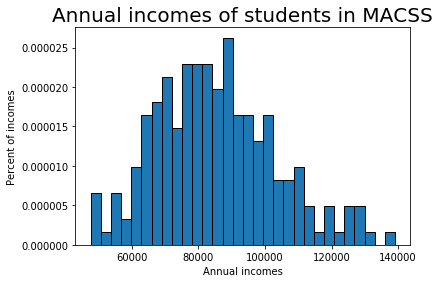

In [33]:
num_bins = 30
count, bins, ignored = plt.hist(incomes, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of students in MACSS', fontsize=20)
plt.xlabel(r'Annual incomes')
plt.ylabel(r'Percent of incomes')
plt.show()

#### (b)

In [34]:
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, s = sigma, scale = np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, s = sigma, scale = np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, s = sigma, scale = np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, s = sigma, scale = np.exp(mu)))
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [35]:
def data_moments(xvals):
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

In [36]:
def model_moments(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    std_model = np.sqrt(var_model)
    
    return mean_model, std_model

In [37]:
def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [38]:
def criterion(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [39]:
mu_init = 11.0
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (incomes, 0.0, 150000.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1 =', mu_GMM1, ' sig_GMM1 =', sig_GMM1)

mu_GMM1 = 11.33359961340107  sig_GMM1 = 0.21325529509280985


In [40]:
mean_data, std_data = data_moments(incomes)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
err1 = err_vec(incomes, mu_GMM1, sig_GMM1, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard deviation of points =', std_data)
print('Mean of model =', mean_model, ', Standard deviation of model =', std_model)
print('Error vector=', err1)
print('GMM criterion function: ', results.fun)

Mean of points = 85276.82360625811 , Standard deviation of points = 17992.542128046523
Mean of model = 85276.82405854897 , Standard deviation of model = 17992.54168300948
Error vector= [ 5.30379577e-09 -2.47345284e-08]
GMM criterion function:  [[6.39927142e-16]]


We can tell that the data moments are nearly the same the model moments.

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


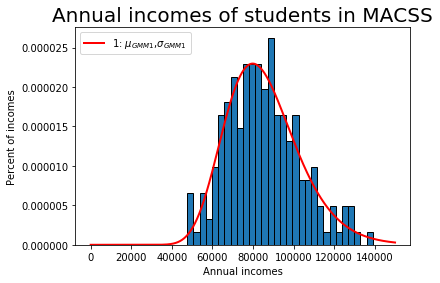

In [41]:
# Plot the histogram of the data
num_bins = 30
count, bins, ignored = plt.hist(incomes, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of students in MACSS', fontsize=20)
plt.xlabel(r'Annual incomes')
plt.ylabel(r'Percent of incomes')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0.0, 150000.0, 3000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000.0),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.show()

#### (c)

In [42]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - std_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - std_model) / std_model
    
    return Err_mat

In [43]:
Err_mat = get_Err_mat2(incomes, mu_GMM1, sig_GMM1, 0.0, 150000.0, False)
VCV2 = (1 / incomes.shape[0]) * (Err_mat @ Err_mat.T)
print("VCV2: {}".format(VCV2))
W_hat2 = lin.inv(VCV2)
print("W_hat2: {}".format(W_hat2))

VCV2: [[4.45167060e-02 1.68385288e+03]
 [1.68385288e+03 9.54184437e+08]]
W_hat2: [[ 2.40701668e+01 -4.24767141e-05]
 [-4.24767141e-05  1.12297423e-09]]


In [44]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (incomes, 0.0, 150000.0, W_hat2)
results_2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results_2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 11.33359961340107  sig_GMM2= 0.21325529509280985


In [45]:
mean_data, std_data = data_moments(incomes)
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 0.0, 150000.0)
err2 = err_vec(incomes, mu_GMM2, sig_GMM2, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard deviation of points =', std_data)
print('Mean of model =', mean_model2, ', Standard deviation of model =', std_model2)
print('Error vector=', err2)
print('GMM criterion function: ', results_2.fun)

Mean of points = 85276.82360625811 , Standard deviation of points = 17992.542128046523
Mean of model = 85276.82405854897 , Standard deviation of model = 17992.54168300948
Error vector= [ 5.30379577e-09 -2.47345284e-08]
GMM criterion function:  [[6.77110945e-16]]


The data moments are vary close to the model moments, and their differences are quite small.

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


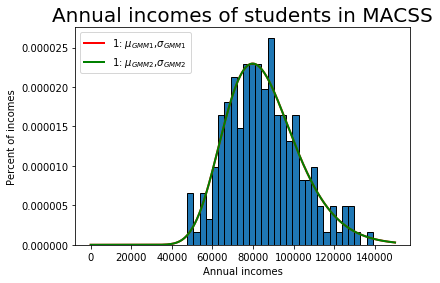

In [48]:
# Plot the histogram of the data
num_bins = 30
count, bins, ignored = plt.hist(incomes, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of students in MACSS', fontsize=20)
plt.xlabel(r'Annual incomes')
plt.ylabel(r'Percent of incomes')

# Plot the estimated GMM PDF with identity matrix
dist_pts = np.linspace(0.0, 150000.0, 3000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000.0),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

# Plot the estimated GMM PDF with optimal weighting matrix
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 0.0, 150000.0),
         linewidth=2, color='g', label='1: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')
plt.show()

#### (d)

In [49]:
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

In [50]:
def model_moments3(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

In [51]:
def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat= data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [52]:
def criterion3(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [53]:
W_hat1_3 = np.eye(3)
gmm_args = (incomes, 0.0, 150000.0, W_hat1_3)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_ 3=', sig_GMM1_3)

mu_GMM1_3= 11.33670517992345  sig_GMM1_ 3= 0.21151351610769906


In [54]:
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(incomes)
bpct_1_model, bpct_2_model, bpct_3_model = model_moments3(mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0)
err3 = err_vec3(incomes, mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False).reshape(3,)
print("Data Moments: percent < 75000: {}, percent 75000 ~ 100000: {}, percent > 100000: {}".format(
    bpct_1_dat, bpct_2_dat, bpct_3_dat))
print("Model Moments: percent < 75000: {}, percent 75000 ~ 100000: {}, percent > 100000: {}".format(
    bpct_1_model, bpct_2_model, bpct_3_model))
print('Error vector=', err3)
print('GMM criterion function: ', results_3.fun)

Data Moments: percent < 75000: 0.3, percent 75000 ~ 100000: 0.5, percent > 100000: 0.2
Model Moments: percent < 75000: 0.30000000341304606, percent 75000 ~ 100000: 0.5000000059130668, percent > 100000: 0.19999999067388746
Error vector= [ 1.13768202e-08  1.18261336e-08 -4.66305627e-08]
GMM criterion function:  [[2.44369886e-15]]


Here we can tell that the data moments are really close to the model moments.

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


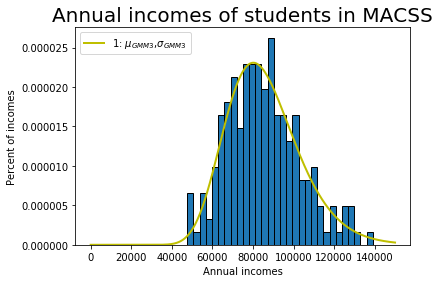

In [55]:
# Plot the histogram of the data
num_bins = 30
count, bins, ignored = plt.hist(incomes, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of students in MACSS', fontsize=20)
plt.xlabel(r'Annual incomes')
plt.ylabel(r'Percent of incomes')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0,  150000.0, 3000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0),
         linewidth=2, color='y', label='1: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')
plt.show()

#### (e)

In [56]:
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):

    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [57]:
Err_mat3 = get_Err_mat3(incomes, mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False)
VCV2_3 = (1 / incomes.shape[0]) * (Err_mat3 @ Err_mat3.T)
print("VCV2_3: {}".format(VCV2_3))
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_3 = lin.pinv(VCV2_3)
print("W_hat2_3: {}".format(W_hat2_3))

VCV2_3: [[ 2.33333328 -0.99999998 -1.00000004]
 [-0.99999998  0.99999998 -1.00000003]
 [-1.00000004 -1.00000003  4.00000037]]
W_hat2_3: [[ 0.25761773 -0.14958449 -0.01246537]
 [-0.14958449  0.11911357 -0.07340719]
 [-0.01246537 -0.07340719  0.20221605]]


In [58]:
params_init = np.array([mu_GMM1_3, sig_GMM1_3])
gmm_args = (incomes, 0.0, 150000.0, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                          method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
print('mu_GMM2_3=', mu_GMM2_3, ' sig_GMM2_3=', sig_GMM2_3)

mu_GMM2_3= 11.33670517992345  sig_GMM2_3= 0.21151351610769906


In [59]:
bpct_1_dat2, bpct_2_dat2, bpct_3_dat2 = data_moments3(incomes)
bpct_1_model2, bpct_2_model2, bpct_3_model2 = model_moments3(mu_GMM2_3, sig_GMM2_3, 0.0, 150000.0)
err3 = err_vec3(incomes, mu_GMM2_3, sig_GMM2_3, 0.0, 150000.0, False).reshape(3,)
print("Data Moments: percent < 75000: {}, percent 75000 ~ 100000: {}, percent > 100000: {}".format(
    bpct_1_dat2, bpct_2_dat2, bpct_3_dat2))
print("Model Moments: percent < 75000: {}, percent 75000 ~ 100000: {}, percent > 100000: {}".format(
    bpct_1_model2, bpct_2_model2, bpct_3_model2))
print('Error vector=', err3)
print('GMM criterion function: ', results2_3.fun)

Data Moments: percent < 75000: 0.3, percent 75000 ~ 100000: 0.5, percent > 100000: 0.2
Model Moments: percent < 75000: 0.30000000341304606, percent 75000 ~ 100000: 0.5000000059130668, percent > 100000: 0.19999999067388746
Error vector= [ 1.13768202e-08  1.18261336e-08 -4.66305627e-08]
GMM criterion function:  [[5.43640158e-16]]


Again, these three data moments are almost the same as those three model moments.

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


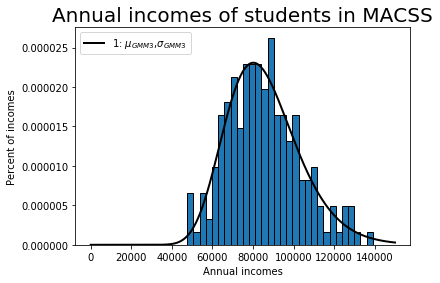

In [62]:
# Plot the histogram of the data
num_bins = 30
count, bins, ignored = plt.hist(incomes, num_bins, density=True, edgecolor='k')
plt.title('Annual incomes of students in MACSS', fontsize=20)
plt.xlabel(r'Annual incomes')
plt.ylabel(r'Percent of incomes')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0,  150000.0, 3000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2_3, sig_GMM2_3, 0.0, 150000.0),
         linewidth=2, color='k', label='1: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')
plt.show()

#### (f)

GMM criterion values for four methods above are: (b) 6.39927099e-16, (c) 6.77113516e-16, (d) 2.44369935e-15, (e) 5.43640277e-16.
Therefore, GMM criterion value using 3 moments and weighted matrix (e) is the smallest. So I think the estimation from (e) fits the data better than the other three estimations.

### Problem 2

In [63]:
data = pd.read_csv("sick.txt")
data

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90
5,0.62,44.67,1.20,68.60
6,1.06,27.92,1.84,29.42
7,1.29,44.87,2.40,50.49
8,1.05,53.68,1.65,55.12
9,1.18,39.63,1.96,37.30


#### (a)

In [64]:
sick = data['sick']
age = data['age']
children = data['children']
temp_winter = data['avgtemp_winter']

In [65]:
def err_vec(beta_0, beta_1, beta_2, beta_3, sick, age, children, temp_winter):
    data_moment = sick
    model_moment = beta_0 + beta_1 * age + beta_2 * children + beta_3 * temp_winter
    err_vec = model_moment - data_moment
    
    return err_vec

In [66]:
def criterion(params, *args):
    beta_0, beta_1, beta_2, beta_3 = params
    sick, age, children, temp_winter, W = args
    err = err_vec(beta_0, beta_1, beta_2, beta_3, sick, age, children, temp_winter)
    
    crit_val = np.array(err.T) @ W @ np.array(err) 
    
    return crit_val

In [67]:
beta_0_init = 0.1
beta_1_init = 0
beta_2_init = 0
beta_3_init = 0
W_hat = np.eye(data.shape[0])
params_init = np.array([beta_0_init, beta_1_init, beta_2_init, beta_3_init])
args_GMM = (sick, age, children, temp_winter, W_hat)
results = opt.minimize(criterion, params_init, args=(args_GMM), method='L-BFGS-B')
results

      fun: 0.0018212896212793988
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.46780633e-05, -4.95789716e-04, -2.01685695e-04,  2.51464648e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 125
      nit: 17
   status: 0
  success: True
        x: array([ 0.25164368,  0.01293369,  0.40049871, -0.0099918 ])

In [70]:
beta_0_MLE, beta_1_MLE, beta_2_MLE, beta_3_MLE = results.x

print("beta_0 = {}".format(beta_0_MLE))
print("beta_1 = {}".format(beta_1_MLE))
print("beta_2 = {}".format(beta_2_MLE))
print("beta_3 = {}".format(beta_3_MLE))
print("The GMM criterion function value = {}".format(results.fun))

beta_0 = 0.2516436843726944
beta_1 = 0.012933693048507446
beta_2 = 0.4004987087341473
beta_3 = -0.009991804074448734
The GMM criterion function value = 0.0018212896212793988
